In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import random
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score
import torchvision.transforms as transforms
import argparse
import numpy as np
from dataloader import Well1ImageMaskDataset

In [9]:
def gaussian_filter(img, sigma = 20):
    # Fourier Transform
    f_transform = np.fft.fft2(img)  # Compute the FFT
    f_shifted = np.fft.fftshift(f_transform)  # Shift zero frequency to the center

    # Get center coordinates
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    # Create a Gaussian mask for low-pass filtering  sigma param default 30  
    # Generate a 2D Gaussian kernel
    x = np.linspace(-ccol, ccol, cols)
    y = np.linspace(-crow, crow, rows)
    X, Y = np.meshgrid(x, y)
    gaussian_mask = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    
    # Apply the filter to the frequency domain
    filtered_f_shifted = f_shifted * gaussian_mask
    
    # Visualize the filtered frequency domain
    # filtered_magnitude = np.log1p(np.abs(filtered_f_shifted))

    # Perform the inverse shift
    inverse_shift = np.fft.ifftshift(filtered_f_shifted)
    
    # Inverse Fourier Transform
    filtered_img = np.fft.ifft2(inverse_shift)
    
    # Get the real part and normalize for visualization
    filtered_img = np.abs(filtered_img)
    if np.max(filtered_img) > 0:  # Avoid division by zero
        filtered_img = (filtered_img / np.max(filtered_img) * 255).astype(np.uint8)
    
    return filtered_img

In [10]:
def preprocess_and_evaluate(dataset):
    filtered_images = []
    iou_scores = []
    dice_scores = []
    recall_scores = []
    precision_scores = []

    for i in range(len(dataset)):
        img, mask = dataset[i]  # img: (C, H, W), mask: (1, H, W)

        # Loop through each channel and apply Gaussian filter
        filtered_channels = []
        for c in range(img.shape[0]):
            channel = img[c]

            channel_np = channel.cpu().numpy()

            # Apply Gaussian filter
            filtered_channel = gaussian_filter(channel_np)
            filtered_channels.append(torch.tensor(filtered_channel, dtype=torch.float32))

        filtered_img = torch.stack(filtered_channels, dim=0) # Stack filtered channels
        avg_filtered_img = torch.mean(filtered_img, dim=0)/255.0  # Average across channels, shape: (H, W)
        binary_mask = (avg_filtered_img > torch.quantile(avg_filtered_img, 0.8)).float()  # Apply threshold at 0.5 to get a binary mask
        
        mask_np = mask.squeeze().cpu().numpy()  # Ground truth mask
        binary_mask_np = binary_mask.cpu().numpy()  # Predicted mask
        
        if i == 9:
            # Plot the ground truth and predicted masks side-by-side
            plt.figure(figsize=(10, 5))
            
            # Ground Truth Mask
            plt.subplot(1, 3, 1)
            plt.imshow(mask_np, cmap='gray')
            plt.title('Ground Truth Mask')
            plt.axis('off')
            
            # Predicted Channel
            plt.subplot(1, 3, 2)
            plt.imshow(avg_filtered_img.squeeze().cpu().numpy(), cmap='gray')
            plt.title('Filtered Image')
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(binary_mask.squeeze(), cmap='gray', vmin=0, vmax=1)
            plt.title('Predicted Mask')
            plt.axis('off')
            plt.show()

            # Show the plot
            plt.tight_layout()
            plt.show()

        # Compute metrics
        intersection = np.logical_and(binary_mask_np, mask_np).sum()
        union = np.logical_or(binary_mask_np, mask_np).sum()
        tp = intersection
        fp = binary_mask_np.sum() - tp
        fn = mask_np.sum() - tp

        iou = intersection / union if union != 0 else 0.0
        dice = (2 * intersection) / (binary_mask_np.sum() + mask_np.sum()) if (binary_mask_np.sum() + mask_np.sum()) != 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0

        # Store results
        iou_scores.append(iou)
        dice_scores.append(dice)
        recall_scores.append(recall)
        precision_scores.append(precision)

        # Store filtered image and mask
        filtered_images.append((binary_mask, mask))

    # Calculate average metrics across the dataset
    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_precision = sum(precision_scores) / len(precision_scores)

    # Return results
    final_metrics = {
        'Average IoU': avg_iou,
        'Average Dice': avg_dice,
        'Average Recall': avg_recall,
        'Average Precision': avg_precision
    }

    return final_metrics

In [11]:
data_path = "/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/"
image_dirs = [data_path + 'brightfield/Alexa488_Fibroblasts_well1_50locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well2_200locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well3_200locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well4_225locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well5_225locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well6_135locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well7_135locations']
mask_dir = data_path + 'masks'

def set_seed(seed=111):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
    random.seed(seed)
    np.random.seed(seed)

set_seed()

data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
mask_transform = data_transform

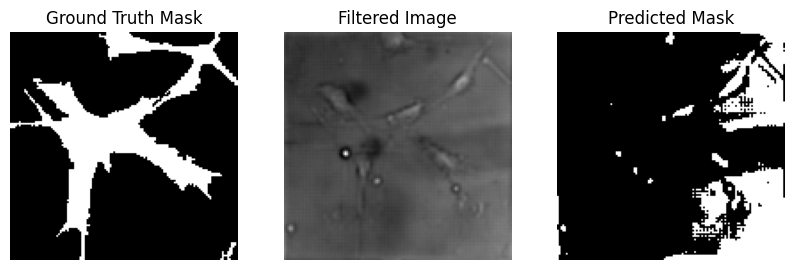

<Figure size 640x480 with 0 Axes>

In [12]:
test_dataset = Well1ImageMaskDataset(image_dir=image_dirs[0], mask_dir=mask_dir, transform=data_transform, mask_transform=mask_transform, channel_indices=None)
metrics = preprocess_and_evaluate(test_dataset)

In [13]:
print(metrics)

{'Average IoU': np.float64(0.1066537311030939), 'Average Dice': np.float64(0.1893256775204283), 'Average Recall': np.float64(0.21038268670573912), 'Average Precision': np.float64(0.18472021887732587)}
